In [1]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install torchvision

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install qiskit

Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import qiskit
from qiskit import transpile, assemble
from qiskit.visualization import *

In [5]:
torch.cat((torch.Tensor([0.2]), 1 - torch.Tensor([0.2])), -1)

tensor([0.2000, 0.8000])

In [6]:
torch.cat((torch.Tensor([[0.2]]), 1 - torch.Tensor([[0.2]])), -1)

tensor([[0.2000, 0.8000]])

In [7]:
class QuantumCircuit:
    """ 
    This class provides a simple interface for interaction 
    with the quantum circuit 
    """
    
    def __init__(self, n_qubits, backend, shots):
        # --- Circuit definition ---
        self._circuit = qiskit.QuantumCircuit(n_qubits)
        self.n_qubits = n_qubits
        all_qubits = [i for i in range(n_qubits)]
        
        self._circuit.h(all_qubits)
        self._circuit.barrier()
        
        self.theta = []
        for i in range(n_qubits):
            self.theta.append(qiskit.circuit.Parameter('theta' + str(i)))
            self._circuit.ry(self.theta[-1], i)
        
        self._circuit.measure_all()
        # ---------------------------
        
        self.backend = backend
        self.shots = shots

    def run(self, thetas):
        #print('in the run')
        #print('theta = ', thetas)
        t_qc = transpile(self._circuit,
                         self.backend)
        dict_for_use = {}
        for i in range(len(self.theta)):
            dict_for_use[self.theta[i]] = thetas[i]
        qobj = assemble(t_qc,
                        shots=self.shots,
                        parameter_binds = [dict_for_use])
        
        job = self.backend.run(qobj)
        result = job.result().get_counts()
        
        #print(result)
        collection = [0] * self.n_qubits
        #It means the probability of '1' for each qubit
        for str_ in list(result.keys()):
            for j in range(len(str_)):
                if int(str_[len(str_) - 1 - j]):
                    collection[j] += 1/self.shots * result[str_]
        
        #print('collection = ', collection)
        
        return collection

In [8]:
bool(int('0'))

False

In [9]:
a = torch.Tensor([1, 2, 3])
np.sum(np.array(a))

6.0

In [10]:
simulator = qiskit.Aer.get_backend('aer_simulator')

circuit = QuantumCircuit(3, simulator, 1000)
#print('Expected value for rotation pi {}'.format(circuit.run([np.pi])[0]))
circuit._circuit.draw()

┌───┐ ░ ┌────────────┐ ░ ┌─┐      
   q_0: ┤ H ├─░─┤ Ry(theta0) ├─░─┤M├──────
        ├───┤ ░ ├────────────┤ ░ └╥┘┌─┐   
   q_1: ┤ H ├─░─┤ Ry(theta1) ├─░──╫─┤M├───
        ├───┤ ░ ├────────────┤ ░  ║ └╥┘┌─┐
   q_2: ┤ H ├─░─┤ Ry(theta2) ├─░──╫──╫─┤M├
        └───┘ ░ └────────────┘ ░  ║  ║ └╥┘
meas: 3/══════════════════════════╩══╩══╩═
                                  0  1  2

In [11]:
circuit.run([0, 0, 0])

[0.51, 0.503, 0.479]

In [12]:
torch.tensor([[1, 2]])

tensor([[1, 2]])

In [13]:
class HybridFunction(Function):
    """ Hybrid quantum - classical function definition """
    
    @staticmethod
    def forward(ctx, input, quantum_circuit, shift):
        """ Forward pass computation """
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit
        
        #print('input[0].tolist() = ', input[0].tolist())
        expectation_z = ctx.quantum_circuit.run(input[0].tolist())
        #print(expectation_z)
        #here
        result = torch.tensor([expectation_z])
        ctx.save_for_backward(input, result)

        return result
        
    @staticmethod
    def backward(ctx, grad_output):
        """ Backward pass computation """
        input, expectation_z = ctx.saved_tensors
        
        
        input_list = np.array(input.tolist())
        #print('input_list =', input_list)
        shift_right = input_list + np.ones(input_list.shape) * ctx.shift
        shift_left = input_list - np.ones(input_list.shape) * ctx.shift
        
        #print('shift_right =', shift_right)
        #print('shift_left =', shift_left)
        #gradients = []
        #print('grad_output.float() = ', grad_output.float())
        
        for i in range(len(input_list)):
            expectation_right = ctx.quantum_circuit.run(shift_right[i])
            expectation_left  = ctx.quantum_circuit.run(shift_left[i])
            
            gradient = 0.5 * (torch.tensor([expectation_right]) - torch.tensor([expectation_left]))
            #print('gradient = ', gradient)
            gradients = gradient.numpy()
            #gradients.append(gradient)
        #print('gradients = ', gradients)
            
        #gradients = np.array([gradients]).T
        #print('grad_output', grad_output.float())
        #print('gradients', torch.tensor(gradients).float())
        #print('multiply', torch.tensor(gradients).float() * grad_output.float())
        return torch.tensor(gradients).float() * grad_output.float(), None, None

class Hybrid(nn.Module):
    """ Hybrid quantum - classical layer definition """
    
    def __init__(self, num, backend, shots, shift):
        super(Hybrid, self).__init__()
        self.quantum_circuit = QuantumCircuit(num, backend, shots)
        self.shift = shift
        
    def forward(self, input):
        return HybridFunction.apply(input, self.quantum_circuit, self.shift)

In [14]:
torch.Tensor([[0.4950, 0.2]]).numpy().T

array([[0.495],
       [0.2  ]], dtype=float32)

In [15]:
np.array([[torch.Tensor([[0.4950, 0.2]]).numpy() ]]).T

array([[[[0.495]]],


       [[[0.2  ]]]], dtype=float32)

In [16]:
np.array([[torch.Tensor([[0.4950]])]]).T

C:\Users\user\AppData\Local\Temp\ipykernel_16300\193857454.py:1: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  np.array([[torch.Tensor([[0.4950]])]]).T


array([[0.495]], dtype=float32)

In [17]:
print(torch.Tensor([5, 3, 2, 4, 1]))
np.where(torch.Tensor([5, 3, 2, 4, 1]) <= 3)

tensor([5., 3., 2., 4., 1.])


(array([1, 2, 4], dtype=int64),)

In [18]:
# Concentrating on the first 100 samples
n_samples = 100

X_train = datasets.MNIST(root='./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

# Leaving only labels 0 and 1 
idx = np.append(np.where(X_train.targets == 0)[0][:n_samples], 
                np.where(X_train.targets == 1)[0][:n_samples])

for i in range(2, 10):
    idx = np.append(idx, np.where(X_train.targets == i)[0][:n_samples])
    
X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]
train_loader = torch.utils.data.DataLoader(X_train, batch_size=1, shuffle=True)

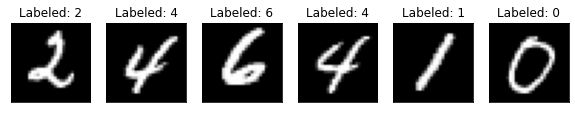

In [19]:
n_samples_show = 6

data_iter = iter(train_loader)

fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

while n_samples_show > 0:
    images, targets = data_iter.__next__()

    axes[n_samples_show - 1].imshow(images[0].numpy().squeeze(), cmap='gray')
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(targets.item()))
    
    n_samples_show -= 1

In [20]:
axes[0]

<AxesSubplot:title={'center':'Labeled: 2'}>

In [21]:
a = torch.Tensor([[0, 0, 0]]).to(float)
a = torch.Tensor(a).to(float)
a

tensor([[0., 0., 0.]], dtype=torch.float64)

In [27]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(256, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 10)
        self.fc3 = nn.Linear(10, 10)
        self.fc4 = nn.Linear(10, 10)
        self.fc5 = nn.Linear(10, 10)
        self.hybrid = Hybrid(10, qiskit.Aer.get_backend('aer_simulator'), 1000, np.pi / 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)

        x = x.flatten(1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.hybrid(x)
        x = self.fc4(x)S
        #x = self.fc5(x)
        
        x = F.softmax(x)
        #print('x = ', x)
        return x

In [28]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()
#loss_func = nn.CrossEntropyLoss()

epochs = 20
loss_list = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        #print(target == 7)
        #print(target.numpy()[0] == 7)
        '''
        if target.numpy()[0] == 7:
            target = torch.LongTensor([0])
            '''
        optimizer.zero_grad()
        # Forward pass
        #print(data.size())
        output = model(data)
        # Calculating loss
        #print('output = ', output)
        #print('target = ', target)
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list[-1]))

C:\Users\user\AppData\Local\Temp\ipykernel_16300\3172363733.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


Training [5%]	Loss: -0.1307
Training [10%]	Loss: -0.2168
Training [15%]	Loss: -0.3050
Training [20%]	Loss: -0.4090
Training [25%]	Loss: -0.4842
Training [30%]	Loss: -0.5446
Training [35%]	Loss: -0.6065
Training [40%]	Loss: -0.6367
Training [45%]	Loss: -0.6641
Training [50%]	Loss: -0.7132
Training [55%]	Loss: -0.7402
Training [60%]	Loss: -0.7626
Training [65%]	Loss: -0.7910
Training [70%]	Loss: -0.8170
Training [75%]	Loss: -0.8386
Training [80%]	Loss: -0.8614
Training [85%]	Loss: -0.8695
Training [90%]	Loss: -0.8859
Training [95%]	Loss: -0.8843
Training [100%]	Loss: -0.8882


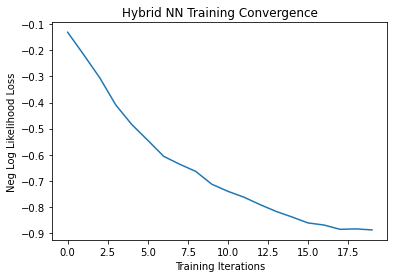

In [29]:
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')
plt.savefig('VQC_middle_layer.png')

In [30]:
# Concentrating on the first 100 samples
n_samples = 50

X_test = datasets.MNIST(root='./data', train=False, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

# Leaving only labels 0 and 1 
idx = np.append(np.where(X_test.targets == 0)[0][:n_samples], 
                np.where(X_test.targets == 1)[0][:n_samples])

for i in range(2, 10):
    idx = np.append(idx, np.where(X_test.targets == i)[0][:n_samples])
    
X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]
#print(X_test.targets)
test_loader = torch.utils.data.DataLoader(X_test, batch_size=1, shuffle=True)

In [31]:
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)
        #print('pred')
        #print(pred)
        #print('target')
        #print(target)
        #print(pred.eq(target.view_as(pred)).sum().item())
        correct += pred.eq(target.view_as(pred)).sum().item()
        #print(output, target)
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

C:\Users\user\AppData\Local\Temp\ipykernel_16300\3172363733.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


Performance on test data:
	Loss: -0.8906
	Accuracy: 95.0%
